In [1]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials
using Random
using JLD2
using DSP
using PythonPlot
mpl = PythonPlot.pyimport("matplotlib")
mpl.rcParams["svg.fonttype"] = "none"

┌ Info: CondaPkg: Waiting for lock to be freed. You may delete this file if no other process is resolving.
│   lock_file = /home/dinosaur/.julia/environments/v1.10/.CondaPkg/lock
└ @ CondaPkg /home/dinosaur/.julia/packages/CondaPkg/TqxCd/src/resolve.jl:589


"none"

In [ ]:
function setup(r) # r specifies radius of simulated spherical cell
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V
    println("V = $(V)")

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,6)
    r0[:,:,1] .= 5 .*(rand.())   # Cdc42-GTPm
    #r0[50,50,1] = 500 # optionally seed polarity sites
    r0[:,:,2] .= 0.5 - mean(r0[:,:,1])*n   # Cdc42-GDPm should be 0.5
    r0[:,:,3] .= 1
    r0[:,:,4] .= 10 .*(rand.())
    r0[:,:,5] .= 1
    r0[:,:,6] .= 0.5 # 0.75
    
    # Dummy parameters used to prevent reallocation on each fxn call
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    Dpak = zeros(N,N)
    Dgef = zeros(N,N)
    Dpakc = zeros(N,N)
    Dgefc = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, Dpak, Dgef, Dpakc, Dgefc, R)
    # Actual parameters
    a = .8
    b = .07*1.25
    c = .05 
    d = .1
    Dm = .01
    Dc = 10
    Dm2 = .1
    n = n

    p = (a, b, c, d, Dm, Dc, Dm2, n, Ax, Ay, dummy)
    return p, r0
end

setup (generic function with 1 method)

In [ ]:
function nonegativeFB!(dr,r,p,t)
    a, b, c, d, Dm, Dc, Dm2, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, Dpak, Dgef, Dpakc, Dgefc, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    pak = @view r[:,:,3]
    gef = @view r[:,:,4]
    pakc = @view r[:,:,5]
    gefc = @view r[:,:,6]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,pak)
    mul!(tAx,pak,Ax)
    @. Dpak = Dm2*(Ayt + tAx)
    mul!(Ayt,Ay,gef)
    mul!(tAx,gef,Ax)
    @. Dgef = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,pakc)
    mul!(tAx,pakc,Ax)
    @. Dpakc = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,gefc)
    mul!(tAx,gefc,Ax)
    @. Dgefc = Dc*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*gef^2*rhoD) - b*rhoT
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
    @. dr[:,:,3] = 0
    @. dr[:,:,4] = c*rhoT*gefc - d*gef + Dgef 
    @. dr[:,:,5] = 0
    @. dr[:,:,6] = n*(- c*rhoT*gefc + d*gef) + Dgefc
end


nonegativeFB! (generic function with 1 method)

In [4]:
function run_pde(radius)
    p, r0 = setup(radius)
    min_prob = ODEProblem(nonegativeFB!,r0,(0.0,3600),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES), saveat=1)#, abstol = 1e-8, reltol = 1e-5 ,saveat=1)
    return sol_simp
end

run_pde (generic function with 1 method)

In [5]:
Random.seed!(1)
sol3noneg = run_pde(3)

V = 113.09733552923254


retcode: Success
Interpolation: 1st order linear
t: 3601-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 3592.0
 3593.0
 3594.0
 3595.0
 3596.0
 3597.0
 3598.0
 3599.0
 3600.0
u: 3601-element Vector{Array{Float64, 3}}:
 [0.36683177234646425 0.835264546438933 … 2.249147211554762 2.173323933861879; 1.7462074477859306 3.5986034627025916 … 4.042108624872047 4.622203430755562; … ; 4.169267240766527 1.8065761920519257 … 1.647577563964819 2.9521148392176446; 4.908521739743653 1.8093785356895964 … 1.5532595482954692 1.13008217989294;;; 0.4749735434055491 0.4749735434055491 … 0.4749735434055491 0.4749735434055491; 0.4749735434055491 0.4749735434055491 … 0.4749735434055491 0.4749735434055491; … ; 0.4749735434055491 0.4749735434055491 … 0.4749735434055491 0.4749735434055491; 0.4749735434055491 0.4749735434055491 … 0.4749735434055491 0.4749735434055491;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;

In [9]:
Random.seed!(3)
sol5noneg = run_pde(5)

V = 523.5987755982989


retcode: Success
Interpolation: 1st order linear
t: 3601-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 3592.0
 3593.0
 3594.0
 3595.0
 3596.0
 3597.0
 3598.0
 3599.0
 3600.0
u: 3601-element Vector{Array{Float64, 3}}:
 [1.6986739459507139 4.4220385254977055 … 4.303168578345623 1.2684746352934029; 4.796164489844406 2.343212185651795 … 2.0883653853306097 3.13287896640823; … ; 3.611423155519292 1.357503299383962 … 2.0817774312499253 1.9170584328130846; 0.910105885423983 0.6810856799394083 … 0.7626353560342519 2.465122406811902;;; 0.48497114955194265 0.48497114955194265 … 0.48497114955194265 0.48497114955194265; 0.48497114955194265 0.48497114955194265 … 0.48497114955194265 0.48497114955194265; … ; 0.48497114955194265 0.48497114955194265 … 0.48497114955194265 0.48497114955194265; 0.48497114955194265 0.48497114955194265 … 0.48497114955194265 0.48497114955194265;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0

In [7]:
Random.seed!(1)
sol9noneg = run_pde(9)

V = 3053.6280592892786


retcode: Success
Interpolation: 1st order linear
t: 3601-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
    ⋮
 3592.0
 3593.0
 3594.0
 3595.0
 3596.0
 3597.0
 3598.0
 3599.0
 3600.0
u: 3601-element Vector{Array{Float64, 3}}:
 [0.36683177234646425 0.835264546438933 … 2.249147211554762 2.173323933861879; 1.7462074477859306 3.5986034627025916 … 4.042108624872047 4.622203430755562; … ; 4.169267240766527 1.8065761920519257 … 1.647577563964819 2.9521148392176446; 4.908521739743653 1.8093785356895964 … 1.5532595482954692 1.13008217989294;;; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497; … ; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497; 0.4916578478018497 0.4916578478018497 … 0.4916578478018497 0.4916578478018497;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;

In [8]:
# These take a long time to simulate. Best to save result.
seed = 1
radius= 3
sol3non = @view sol3noneg[:,:,1,:]
sol5non = @view sol5noneg[:,:,1,:]
sol9non = @view sol9noneg[:,:,1,:]
@save "../sims/nonegFB_r$(radius)_seed$(seed).jld2" sol3non
seed = 3
radius= 5
@save "../sims/nonegFB_r$(radius)_seed$(seed).jld2" sol5non
seed = 1
radius= 9
@save "../sims/nonegFB_r$(radius)_seed$(seed).jld2" sol9non

In [5]:
sol3non = load("../sims/nonegFB_r3_seed1.jld2", "sol3non")
sol5non = load("../sims/nonegFB_r5_seed3.jld2", "sol5non")
sol9non = load("../sims/nonegFB_r9_seed1.jld2", "sol9non")

100×100×3601 view(::ODESolution{Float64, 4, Vector{Array{Float64, 3}}, Nothing, Nothing, Vector{Float64}, Nothing, Nothing, ODEProblem{Array{Float64, 3}, Tuple{Float64, Float64}, true, Tuple{Float64, Float64, Int64, Float64, Float64, Float64, Float64, Float64, Int64, Float64, Float64, Matrix{Float64}, Matrix{Float64}, NTuple{9, Matrix{Float64}}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Array{Float64, 3}, Array{Float64, 3}, Tuple{Float64, Float64, Int64, Float64, Float64, Float64, Float64, Float64, Int64, Float64, Float64, Matrix{Float64}, Matrix{Float64}, NTuple{9, Matrix{Float64}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Array{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}, 3}, Array{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}, 3}, Tuple{Float64, Float64, Int64, Float64, Float64, Fl

In [10]:
function mask_site(sim, threshold; n_sites=1)
    im_array = sim
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [29]:
sol3non = load("../sims/nonegFB_r3_seed1.jld2", "sol3non")
sol5non = load("../sims/nonegFB_r5_seed3.jld2", "sol5non")

100×100×3601 view(::ODESolution{Float64, 4, Vector{Array{Float64, 3}}, Nothing, Nothing, Vector{Float64}, Nothing, Nothing, ODEProblem{Array{Float64, 3}, Tuple{Float64, Float64}, true, Tuple{Float64, Float64, Int64, Float64, Float64, Float64, Float64, Float64, Int64, Float64, Float64, Matrix{Float64}, Matrix{Float64}, NTuple{9, Matrix{Float64}}}, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Array{Float64, 3}, Array{Float64, 3}, Tuple{Float64, Float64, Int64, Float64, Float64, Float64, Float64, Float64, Int64, Float64, Float64, Matrix{Float64}, Matrix{Float64}, NTuple{9, Matrix{Float64}}}, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Array{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}, 3}, Array{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}, 3}, Tuple{Float64, Float64, Int64, Float64, Float64, Fl

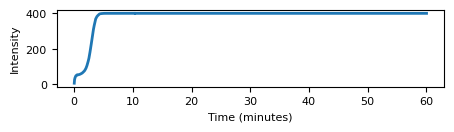

In [10]:
interval = 1
cov_threshold=0.1
time_threshold=.5
masks = mask_site(sol3non, cov_threshold, n_sites=1)
fig, ax = subplots(figsize=(5,1))
for i in 1
    m = masks[:,:,:,i]
    q = maximum(m, dims=(1,2))[1,1,:]
    ax.plot(1/60:1/60:length(q)./60, q, linewidth=2)
end
ax.set_ylabel("Intensity", fontsize=8)
ax.set_xlabel("Time (minutes)", fontsize=8)
ax.tick_params(labelsize=8)

PythonPlot.savefig("../figures/sol3non_fulltrace.svg")
display(gcf())

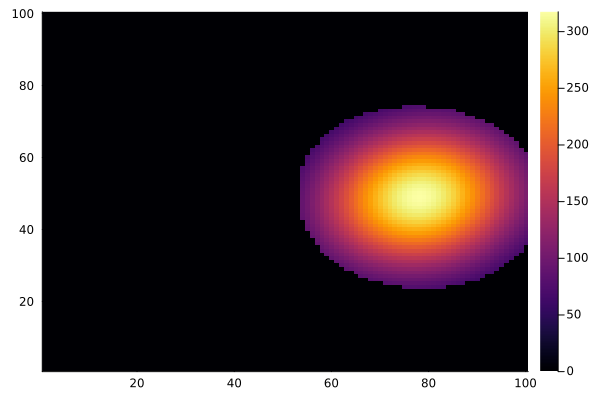

In [11]:
heatmap(masks[:,:,200,1])

In [11]:
#sol5non = load("../sims/nonegFB_r5_seed3.jld2", "sol5non")
sol5non = sol5noneg[:,:,1,:]

100×100×3601 Array{Float64, 3}:
[:, :, 1] =
 1.69867   4.42204    0.143116  1.41774   …  0.0759578  4.30317   1.26847
 4.79616   2.34321    2.05395   3.58072      3.14792    2.08837   3.13288
 4.9999    0.0960537  3.11036   4.30213      2.91428    2.51912   1.76984
 0.460571  1.66007    3.62519   0.910926     1.04466    2.45761   3.17344
 3.49213   0.441485   4.21024   4.59682      2.96049    3.22393   2.81854
 2.48142   0.594966   4.56675   0.503362  …  4.38321    4.80691   4.46723
 4.75709   1.81778    0.364459  1.13814      2.34874    1.13731   1.259
 3.98025   4.37911    1.71484   2.98895      2.88152    2.87518   2.34134
 3.9827    2.11272    1.4289    4.52036      2.41784    4.42611   2.85076
 2.51654   3.63405    2.09245   3.41171      1.12516    3.95425   3.50307
 ⋮                                        ⋱                       
 3.0593    3.86906    0.868421  1.33854      3.89133    3.75228   4.56582
 1.57081   0.36539    0.622899  1.15811      1.54811    0.959159  0.757556
 4

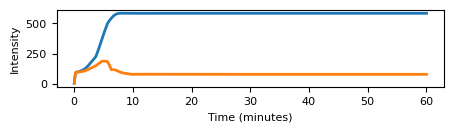

In [12]:
interval = 1
cov_threshold=0.1
time_threshold=.5
masks = mask_site(sol5non, cov_threshold, n_sites=2)
fig, ax = subplots(figsize=(5,1))
for i in 1:2
    m = masks[:,:,:,i]
    q = maximum(m, dims=(1,2))[1,1,:]
    ax.plot(1/60:1/60:length(q)./60, q, linewidth=2)
end
ax.set_ylabel("Intensity", fontsize=8)
ax.set_xlabel("Time (minutes)", fontsize=8)
ax.tick_params(labelsize=8)

#PythonPlot.savefig("../figures/sol5non_fulltrace.svg")
display(gcf())

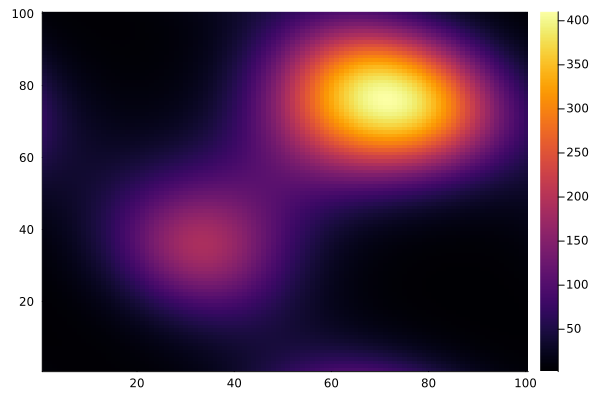

In [13]:
heatmap(sol5non[:,:,300])

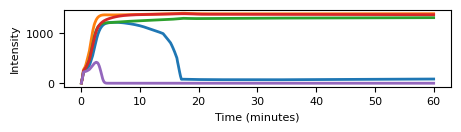

In [56]:
interval = 1
cov_threshold=0.1
time_threshold=.5
masks = mask_site(sol9non, cov_threshold, n_sites=5)
fig, ax = subplots(figsize=(5,1))
for i in 1:5
    m = masks[:,:,:,i]
    q = maximum(m, dims=(1,2))[1,1,:]
    ax.plot(1/60:1/60:length(q)./60, q, linewidth=2)
end
ax.set_ylabel("Intensity", fontsize=8)
ax.set_xlabel("Time (minutes)", fontsize=8)
ax.tick_params(labelsize=8)

PythonPlot.savefig("../figures/sol9non_fulltrace.svg")
display(gcf())

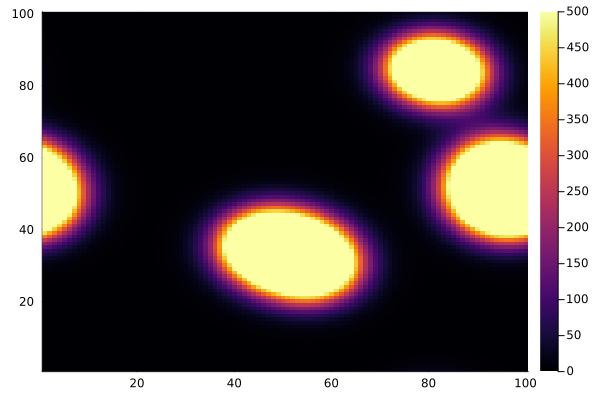

In [15]:
heatmap(sol9non[:,:,60*5], clim=(0,500))
#heatmap(masks[:,:,end,1])

In [30]:
for i in 0:1/2:10
    r = 5
    fig, ax = subplots(figsize=(0.8,0.8))
    ax.imshow(sol3non[:,:,Int(round(i*60+1))], clim=(0,500), cmap="inferno")
    ax.set_axis_off()
    ax.hlines(95 ,xmin=5, xmax=5+(100/3)*1, color="white")
    min = Int(trunc(i)) # zero indexed
    if min > 0
        sec = Int(mod(i,min)*60)
    elseif min == 0
        if i==0
            sec = 0
        else
            sec = 30
        end
    end
    if sec == 0
        sec = "00"
    end
    ax.text(5,20,"$(min):$(sec)", fontsize=8, color="white")
    PythonPlot.savefig("../figures/r3non/sim_r$(r)_t$(i).png", transparent=true)
end

In [33]:
for i in 0:1/2:10
    r = 5
    fig, ax = subplots(figsize=(0.8,0.8))
    ax.imshow(sol5non[:,:,Int(round(i*60+1))], clim=(0,500), cmap="inferno")
    ax.set_axis_off()
    ax.hlines(95 ,xmin=5, xmax=5+(100/5)*1, color="white")
    min = Int(trunc(i)) # zero indexed
    if min > 0
        sec = Int(mod(i,min)*60)
    elseif min == 0
        if i==0
            sec = 0
        else
            sec = 30
        end
    end
    if sec == 0
        sec = "00"
    end
    ax.text(5,20,"$(min):$(sec)", fontsize=8, color="white")
    PythonPlot.savefig("../figures/r5non/sim_r$(r)_t$(i).png", transparent=true)
end

In [32]:
for i in 0:1/2:10
    r = 5
    fig, ax = subplots(figsize=(0.8,0.8))
    ax.imshow(sol9non[:,:,Int(round(i*60+1))], clim=(0,500), cmap="inferno")
    ax.set_axis_off()
    ax.hlines(95 ,xmin=5, xmax=5+(100/9)*1, color="white")
    min = Int(trunc(i)) # zero indexed
    if min > 0
        sec = Int(mod(i,min)*60)
    elseif min == 0
        if i==0
            sec = 0
        else
            sec = 30
        end
    end
    if sec == 0
        sec = "00"
    end
    ax.text(5,20,"$(min):$(sec)", fontsize=8, color="white")
    PythonPlot.savefig("../figures/r9non/sim_r$(r)_t$(i).png", transparent=true)
end